# Boosting to Uniformity

In physical applications frequently we need to achieve uniformity of predictions along some features.
For instance, when testing the existence of new particle, we need classifier to be uniform in background along the mass (otherwise one can get false discovery due to peaking background).

This notebook contains some comparison of classifiers. The target is to obtain flat effiency in __signal__ (without significally loosing quality of classification) in Dalitz features.

The classifiers compared are 
* plain __GradientBoosting__ 
* __uBoost__
* gradient boosting with knn-Ada loss (__UGB+knnAda__) 
* gradient boosting with FlatnessLoss (__UGB+FlatnessLoss__)

We use dataset from paper about `uBoost` for demonstration purposes.
We have plenty of data here, so results are quite stable

In [1]:
!wget -O ../data/dalitzdata.root -nc https://github.com/arogozhnikov/hep_ml/blob/data/data/dalitzdata.root?raw=true

Файл «../data/dalitzdata.root» уже существует; не загружается.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas, numpy
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# this wrapper makes it possible to train on subset of features
from rep.estimators import SklearnClassifier

from hep_ml.commonutils import train_test_split
from hep_ml import uboost, gradientboosting as ugb, losses

###Loading data

In [4]:
import root_numpy
used_columns = ["Y1", "Y2", "Y3", "M2AB", "M2AC"]
data = pandas.DataFrame(root_numpy.root2array('../data/dalitzdata.root', treename='tree'))
labels = data['labels']
data = data.drop('labels', axis=1)

## Distribution of events in different files in the Dalitz features
As we can see, the background is distributed mostly in the corners of Dalitz plot, <br />
and for traditional classifiers this results in poor effieciency of signal in the corners.

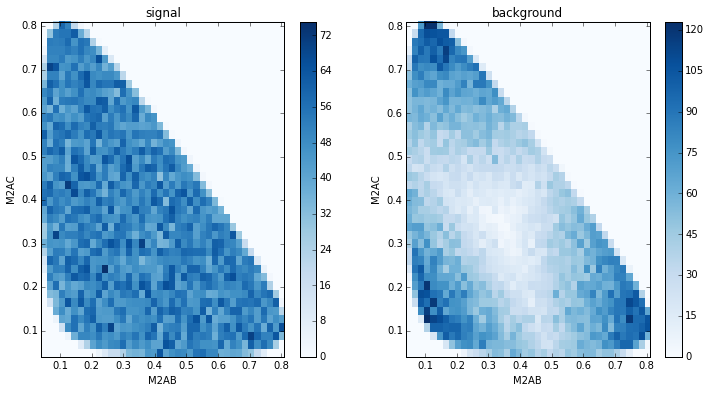

In [5]:
def plot_distribution(data_frame, var_name1='M2AB', var_name2='M2AC', bins=40):
    """The function to plot 2D distribution histograms"""
    pylab.hist2d(data_frame[var_name1], data_frame[var_name2], bins = 40, cmap=cm.Blues)
    pylab.xlabel(var_name1)
    pylab.ylabel(var_name2)
    pylab.colorbar()

pylab.figure(figsize=(12, 6))
subplot(1, 2, 1), pylab.title("signal"),       plot_distribution(data[labels==1])
subplot(1, 2, 2), pylab.title("background"),   plot_distribution(data[labels==0])
pass

## Preparation of train/test datasets

In [6]:
trainX, testX, trainY, testY = train_test_split(data, labels, random_state=42)

## Setting up classifiers, training

In [7]:
uniform_features  = ["M2AB", "M2AC"]
train_features = ["Y1", "Y2", "Y3"]
n_estimators = 150
base_estimator = DecisionTreeClassifier(max_depth=4)

__uBoost__ training takes much time, so we reduce number of efficiency_steps, use prediction smoothing and run uBoost in threads

In [8]:
from rep.metaml import ClassifiersFactory

classifiers = ClassifiersFactory()

base_ada = GradientBoostingClassifier(max_depth=4, n_estimators=n_estimators, learning_rate=0.1)
classifiers['AdaBoost'] = SklearnClassifier(base_ada, features=train_features)


knnloss = ugb.KnnAdaLossFunction(uniform_features, knn=10, uniform_label=1)
ugbKnn = ugb.UGradientBoostingClassifier(loss=knnloss, max_depth=4, n_estimators=n_estimators,
                                        learning_rate=0.4, train_features=train_features)
classifiers['uGB+knnAda'] = SklearnClassifier(ugbKnn) 

uboost_clf = uboost.uBoostClassifier(uniform_features=uniform_features, uniform_label=1,
                                     base_estimator=base_estimator, 
                                     n_estimators=n_estimators, train_features=train_features, 
                                     efficiency_steps=12, n_threads=4)
classifiers['uBoost'] = SklearnClassifier(uboost_clf)

flatnessloss = ugb.KnnFlatnessLossFunction(uniform_features, fl_coefficient=3., power=1.3, uniform_label=1)
ugbFL = ugb.UGradientBoostingClassifier(loss=flatnessloss, max_depth=4, 
                                       n_estimators=n_estimators, 
                                       learning_rate=0.1, train_features=train_features)
classifiers['uGB+FL'] = SklearnClassifier(ugbFL)


classifiers.fit(trainX, trainY, parallel_profile='threads-4')
pass

model AdaBoost     was trained in 86.50 seconds
model uGB+knnAda   was trained in 156.14 seconds
model uBoost       was trained in 443.68 seconds
model uGB+FL       was trained in 308.80 seconds
Totally spent 443.68 seconds on training


## Lets look at the results of training
dependence of quality on the number of trees built (ROC AUC - area under the ROC curve, the more the better)

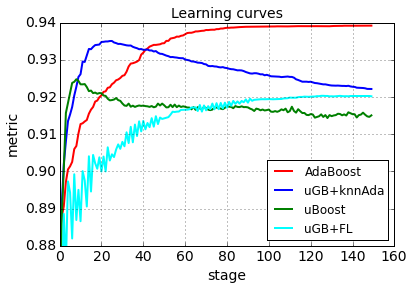

In [9]:
from rep.report.metrics import RocAuc
report = classifiers.test_on(testX, testY)

ylim(0.88, 0.94)
report.learning_curve(RocAuc(), steps=1)

## SDE (squared deviation of efficiency) learning curve
SDE vs the number of built trees. SDE is memtric of nonuniformity - less is better. 

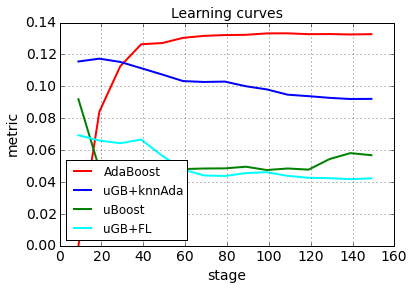

In [10]:
from hep_ml.metrics import BinBasedSDE, KnnBasedCvM
report.learning_curve(BinBasedSDE(uniform_features, uniform_label=1))

##CvM learning curve
CvM is metric of non-uniformity based on Cramer-von Mises distance. We are using Knn version now.

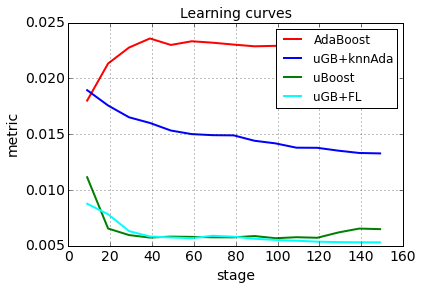

In [11]:
report.learning_curve(KnnBasedCvM(uniform_features, uniform_label=1))

# ROC curves after training

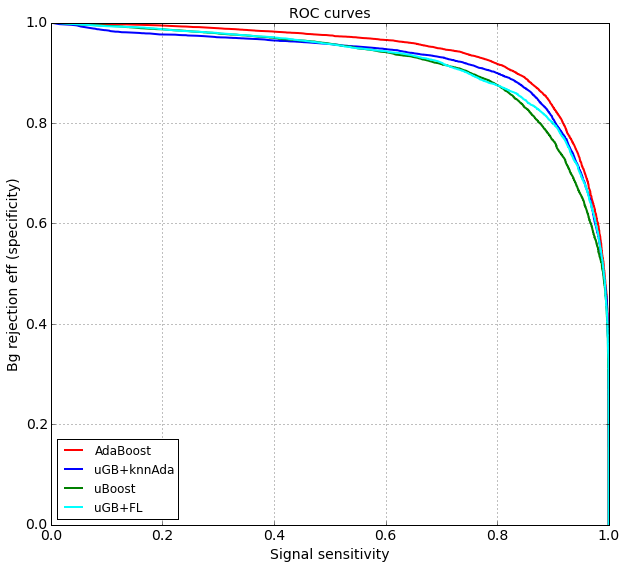

In [12]:
report.roc().plot(new_plot=True, figsize=[10, 9])

## Signal efficiency 
global cut corresponds to average signal efficiency=0.5. In ideal case the picture shall be white.

/Users/axelr/venvs/rep_env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


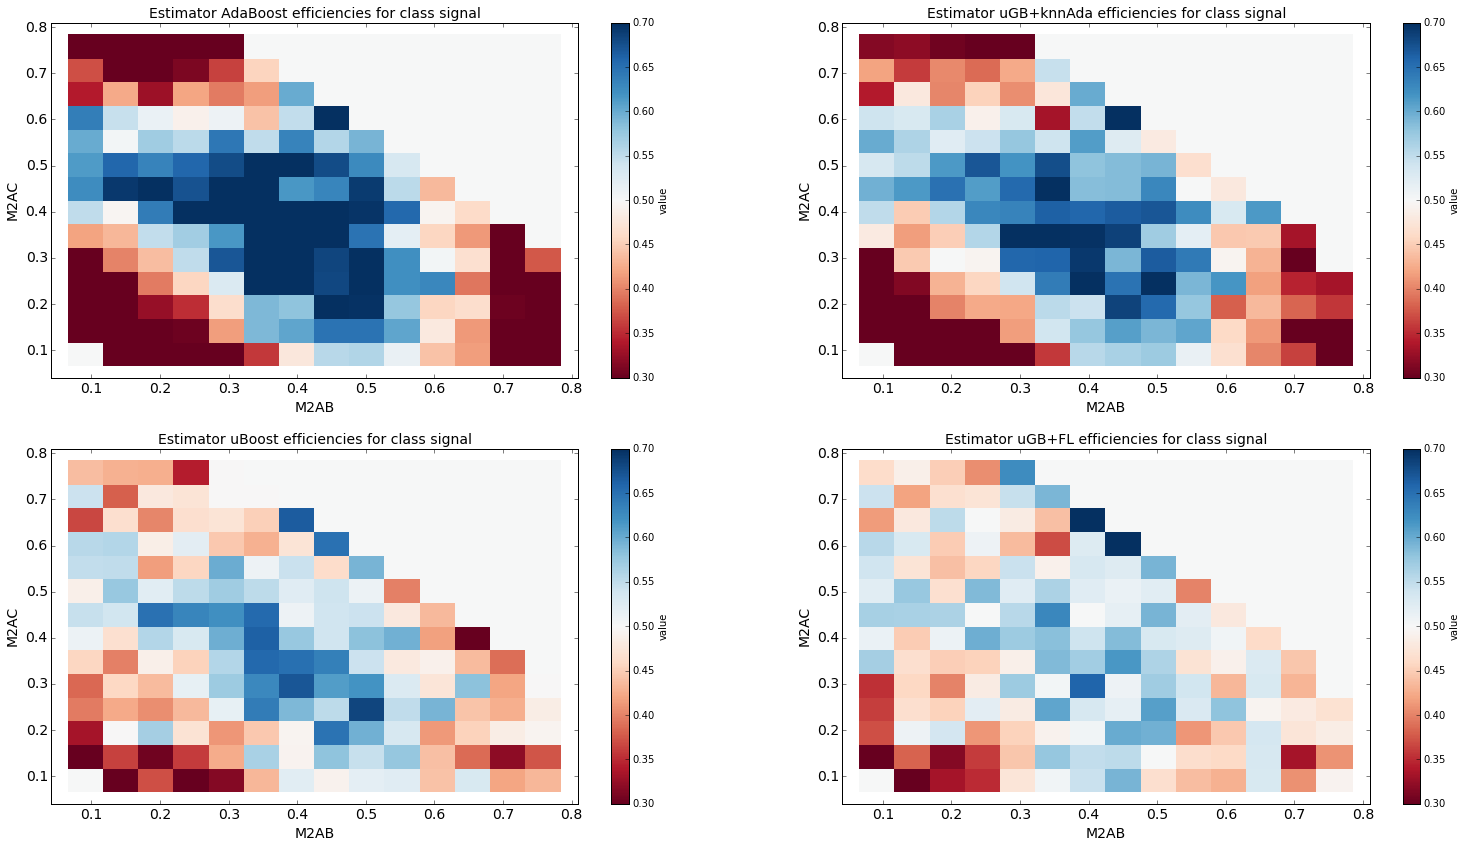

In [13]:
report.efficiencies_2d(uniform_features, efficiency=0.5, signal_label=1, n_bins=15, 
                       labels_dict={1: 'signal'})

the same for global efficiency = 0.7

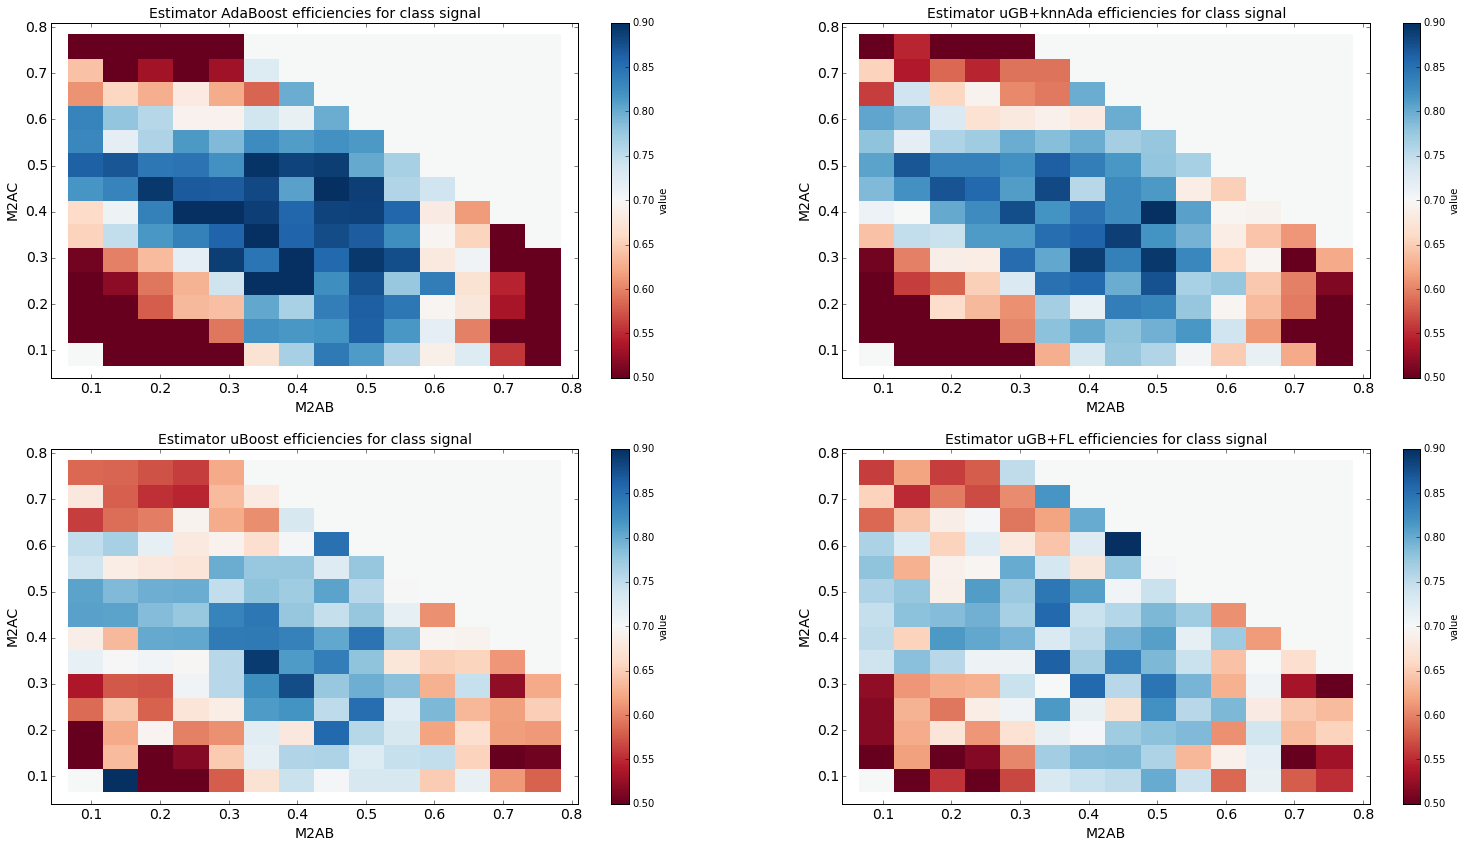

In [14]:
report.efficiencies_2d(uniform_features, efficiency=0.7, signal_label=1, n_bins=15, 
                       labels_dict={1: 'signal'})